In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from helpers import *

d:\anaconda\envs\pytorch_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SumLayer(nn.Linear):
    def __init__(self, criteria_nr, sum_layer_weight_std=0, **kwargs):
        super().__init__(criteria_nr, 1, bias=False)
        self.weight = nn.Parameter(
            (torch.zeros(1, criteria_nr).uniform_(-1, 1) * sum_layer_weight_std + 1)
            / criteria_nr
        )

    def w(self):
        return torch.clamp(self.weight, 0.01)

    def forward(self, x):
        return (x * self.w()).sum(1).view(-1, 1)

In [3]:
class CriterionLayerSpread(nn.Module):
    def __init__(
        self,
        criteria_nr,
        hidden_nr,
        input_range=(0, 1),
        criterion_layer_spread_normalize_bias=False,
        **kwargs
    ):
        input_range = (-input_range[0], -input_range[1])
        self.max_bias = max(input_range)
        self.min_bias = min(input_range)
        super().__init__()
        self.normalize_bias = criterion_layer_spread_normalize_bias
        self.bias = nn.Parameter(torch.FloatTensor(hidden_nr, criteria_nr))
        self.weight = nn.Parameter(torch.FloatTensor(hidden_nr, criteria_nr))
        self.reset_parameters()

    def b(self):
        if self.normalize_bias:
            return torch.clamp(self.bias, self.min_bias, self.max_bias)
        else:
            return self.bias

    def reset_parameters(self):
        nn.init.uniform_(self.weight, 1, 10.0)
        nn.init.uniform_(self.bias, self.min_bias, self.max_bias)

    def w(self):
        return torch.clamp(self.weight, 0.0)

    def forward(self, x):
        return (x + self.b()) * self.w()

In [4]:
class CriterionLayerCombine(nn.Module):
    def __init__(
        self, criteria_nr, hidden_nr, criterionLayerCombine_min_weight=0.0, **kwargs
    ):
        super().__init__()
        self.criterionLayerCombine_min_weight = criterionLayerCombine_min_weight
        self.weight = nn.Parameter(torch.FloatTensor(hidden_nr, criteria_nr))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.weight, 0.2, 1.0)
        self.weight.data = self.weight.data / torch.sum(self.weight.data)

    def w(self):
        return torch.clamp(self.weight, self.criterionLayerCombine_min_weight)

    def forward(self, x):
        return (x * self.w()).sum(1)

In [5]:
class LeakyHardSigmoid(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.slope = 0.01

    def SetSlope(self, val):
        self.slope = val

    def forward(self, x):
        return F.leaky_relu(1.0 - F.leaky_relu(1 - x, self.slope), self.slope)

In [6]:
class Uta(nn.Sequential):
    def __init__(self, criteria_nr, hidden_nr, **kwargs):
        super().__init__()
        self.criterionLayerSpread = CriterionLayerSpread(
            criteria_nr, hidden_nr, **kwargs
        )
        self.activate_function = LeakyHardSigmoid(**kwargs)
        self.criterionLayerCombine = CriterionLayerCombine(
            criteria_nr, hidden_nr, **kwargs
        )
        self.sum_layer = SumLayer(criteria_nr, **kwargs)

    def SetSlope(self, val):
        self.activate_function.slope = val

    def forward(self, x, *args, **kwargs):
        for module in self._modules.values():
            x = module(x)
        return x

In [7]:
class ThresholdLayer(nn.Module):
    def __init__(self, threshold=None, requires_grad=True):
        super().__init__()
        if threshold is None:
            self.threshold = nn.Parameter(
                torch.FloatTensor(1).uniform_(0.1, 0.9), requires_grad=requires_grad
            )
        else:
            self.treshold = nn.Parameter(
                torch.FloatTensor([threshold]), requires_grad=requires_grad
            )

    def forward(self, x):
        return x - self.threshold

In [8]:
class NormLayer(nn.Module):
    def __init__(self, method, criteria_nr):
        super().__init__()
        self.method = method
        self.criteria_nr = criteria_nr
        self.thresholdLayer = ThresholdLayer()

    def forward(self, x, *args):
        self.out = self.method(x)

        zero_input = (
            torch.FloatTensor(self.criteria_nr)
            .zero_()
            .view(1, 1, -1)
            .to(self.out.device)
        )
        self.zero = self.method(zero_input)
        self.one = self.method(zero_input + 1)

        self.out = (self.out - self.zero) / (self.one - self.zero)
        return self.tresholdLayer(self.out)

In [10]:
path = "monodata/lectures evaluation.csv"
data = pd.read_csv(path, header=None)
target_map = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1}
criteria_nr = 4
data_input = data.iloc[:, :criteria_nr]
data_target = data[criteria_nr].apply(lambda x: target_map[x])

data_input = data_input.values.reshape(-1, 1, criteria_nr)

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values, test_size=0.2, random_state=1234
)

In [11]:
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [ ]:
PATH = "uta.pt2"

In [ ]:
uta = Uta(criteria_nr, 30)
model = NormLayer(uta, criteria_nr)

acc, acc_test, auc, auc_test = Train(model, train_dataloader, test_dataloader, PATH)

print("Accuracy train:\t%.2f%%" % (acc * 100.0))
print("AUC train: \t%.2f%%" % (acc_test * 100.0))
print()
print("Accuracy test:\t%.2f%%" % (auc * 100.0))
print("AUC test: \t%.2f%%" % (auc_test * 100.0))

100%|████████████████████████████████████████| 200/200 [00:08<00:00, 23.96it/s]

Accuracy train:	81.38%
AUC train: 	85.00%

Accuracy test:	85.47%
AUC test: 	88.60%


In [ ]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [ ]:
def getSimpleInput(val):
    return torch.FloatTensor([[val] * criteria_nr]).view(1, 1, -1).cpu()


hook = Hook(model.method.criterionLayerCombine, append_output)
xs = []
with torch.no_grad():
    for i in range(201):
        val = i / 200.0
        x = getSimpleInput(val)
        xs.append(val)
        model(x)

outs = np.array(torch.stack(hook.stats)[:, 0].detach().cpu())
outs = outs * model.method.sum_layer.weight.detach().numpy()[0]
outs = outs[::3] - outs[::3][0]
outs = outs / outs[-1].sum()

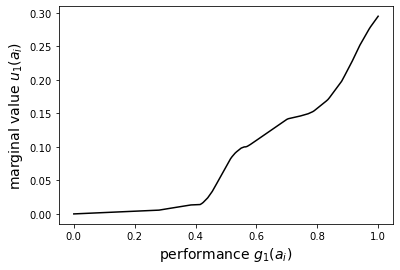

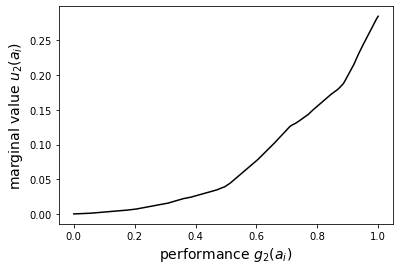

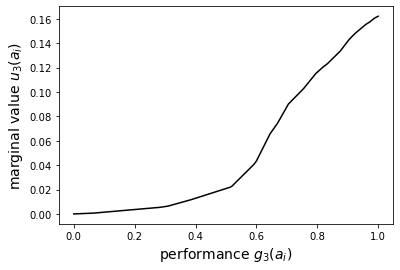

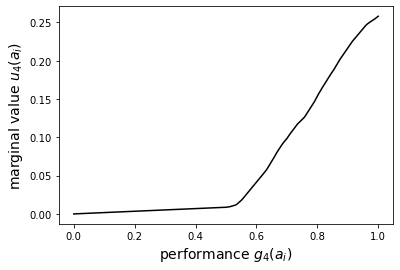

In [ ]:
for i in range(criteria_nr):
    plt.plot(xs, outs[:, i], color="black")
    plt.ylabel("marginal value $u_{0}(a_i)$".format(i + 1), fontsize=14)
    plt.xlabel("performance $g_{0}(a_i)$".format(i + 1), fontsize=14)
    plt.show()